Edited notebook from tensorflow [tutorial](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data) on working with imbalanced data.

### TASK 2: DISEASE CLASSIFICATION FROM IMAGE FEATURES

This task is primarily concerned with multi-class classification where you have 3 classes. However, we have changed the original image features in several ways. You will need to deal with class imbalance; in the training set, there are 600 examples from class 0 and 2 but 3600 examples from class 1. Test set has the same class imbalance as the training set.

## Setup

In [36]:
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasClassifier

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [37]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Data processing and exploration

DISEASE CLASSIFICATION FROM IMAGE FEATURES

This task is primarily concerned with multi-class classification where you have 3 classes. However, we have changed the original image features in several ways. You will need to deal with class imbalance; in the training set, there are 600 examples from class 0 and 2 but 3600 examples from class 1. Test set has the same class imbalance as the training set.

In [38]:
#X_test = pd.read_csv('./data/X_test.csv')
#X_train = X_train.drop(columns='id').to_numpy()
#y_train = y_train.drop(columns='id').to_numpy()[:, 0]
#X_test = X_test.drop(columns='id').to_numpy()

X_train = pd.read_csv('./data/X_train.csv')
y_train = pd.read_csv('./data/y_train.csv')
X_train['y'] = y_train['y']
raw_df = X_train.drop(['id'], axis=1)
raw_df.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x991,x992,x993,x994,x995,x996,x997,x998,x999,y
0,-1.498973,1.448201,2.784979,1.905992,1.285007,-0.571679,1.253798,-2.590709,1.379211,-1.553323,...,-1.365574,2.856497,-1.916006,1.406900,-2.581604,0.839115,-0.004883,3.173465,2.179183,1
1,-0.521470,-0.493049,0.891382,-0.080855,0.227825,-0.167394,-0.426608,0.371071,-0.065361,-0.271039,...,-0.443464,-0.540985,-0.164082,0.223598,0.274742,-0.122392,0.971394,0.604963,0.355499,0
2,-0.417724,-0.019106,0.938377,-0.670472,0.298922,0.917788,0.189585,-0.259406,0.591056,-1.391407,...,-0.543036,-0.321695,-1.778676,1.118608,-0.937445,-0.239242,0.842709,2.086818,0.512741,1
3,-0.471972,0.000398,0.784836,1.088817,-0.436292,0.023086,0.611958,-0.720903,0.310497,-0.703081,...,-1.942345,0.366181,-1.226904,1.152494,-0.104389,0.702375,0.426496,0.336746,1.304973,1
4,0.201026,-0.579901,0.638809,-0.614121,0.468388,0.535726,0.271890,0.054270,0.297078,-0.677568,...,0.203202,-0.150227,-0.026890,0.106822,-1.202451,0.098924,0.825237,1.044778,0.071464,1


In [39]:
desc = raw_df[raw_df.drop(['y'], axis=1).columns.tolist()].describe()
desc

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x990,x991,x992,x993,x994,x995,x996,x997,x998,x999
count,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,...,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000
mean,-0.403221,0.220492,1.106921,0.068664,0.279619,0.388415,0.236717,-0.152921,0.432778,-0.752647,...,0.673128,-0.444427,0.448460,-0.693521,0.540356,-0.729529,0.395605,0.440266,1.240888,0.937046
std,0.663232,0.764817,0.794665,0.888101,0.690293,0.628839,0.625738,0.782704,0.568082,0.573664,...,0.866030,0.706408,0.786608,1.033146,0.707031,0.729511,0.584042,0.574004,0.668117,0.884328
min,-3.026434,-2.177817,-0.993103,-2.958118,-1.992190,-2.229151,-1.620785,-3.842304,-2.046807,-3.980367,...,-1.351814,-3.587288,-2.027416,-4.932804,-1.548640,-3.720113,-1.686527,-2.076105,-1.547162,-1.861970
25%,-0.827374,-0.306275,0.518833,-0.604431,-0.180091,-0.002606,-0.188781,-0.681943,0.096057,-1.084700,...,0.027572,-0.854477,-0.152561,-1.446615,0.039625,-1.209385,0.012024,0.107948,0.773387,0.276949
50%,-0.312958,0.084477,0.933785,-0.061674,0.199699,0.357911,0.147484,-0.049152,0.409125,-0.696674,...,0.473798,-0.344868,0.325952,-0.603889,0.457354,-0.640468,0.335444,0.454828,1.138441,0.752086
75%,0.076125,0.624882,1.585165,0.737608,0.644108,0.753130,0.612462,0.409195,0.752769,-0.361554,...,1.246985,0.048537,0.971055,0.111399,0.978256,-0.192801,0.727108,0.792661,1.625235,1.549565
max,1.769423,4.102255,4.946383,3.461174,3.682944,3.209605,3.303836,2.223731,3.235681,0.823849,...,5.333272,1.840349,3.701539,2.378358,3.393483,2.271806,3.589027,2.841595,5.489396,4.947546


Let's plot the statistics about all features:

Text(0.5, 1.0, 'Stand divs.')

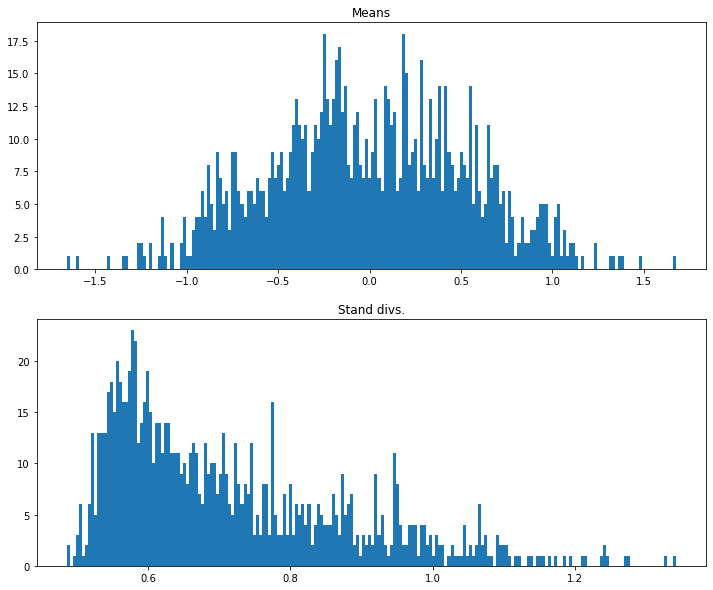

In [56]:
means = desc.loc['mean', :]
stds = desc.loc['std', :]

fig, axs = plt.subplots(2)
axs[0].hist(means, bins=200)
axs[0].set_title('Means')
axs[1].hist(stds, bins=200)
axs[1].set_title('Stand divs.')

### Examine the class label imbalance

Let's look at the dataset imbalance:

In [41]:
cls0, cls1, cls2 = np.bincount(raw_df['y'])
total = cls0 + cls1 + cls2
print('Samples:\n    Total: {}\n \
      Class 0: {} ({:.2f}% of total)\n \
      Class 1: {} ({:.2f}% of total)\n \
      Class 2: {} ({:.2f}% of total)'.format(total, cls0, 100*cls0/total, cls1, 100*cls1/total, cls2, 100*cls2/total))

Samples:
    Total: 4800
       Class 0: 600 (12.50% of total)
       Class 1: 3600 (75.00% of total)
       Class 2: 600 (12.50% of total)


In [47]:
stat_df = raw_df.copy()

# get labels
labels = np.array(stat_df['y'])

# get boolean arrays to split classes
cls0_bool = labels == 0
cls1_bool = labels == 1
cls2_bool = labels == 2

# split classes
cls0_df = stat_df[cls0_bool]
cls1_df = stat_df[cls1_bool]
cls2_df = stat_df[cls2_bool]

# get statistics from the different classes
desc_cls0 = cls0_df[cls0_df.drop(['y'], axis=1).columns.tolist()].describe()
desc_cls1 = cls1_df[cls1_df.drop(['y'], axis=1).columns.tolist()].describe()
desc_cls2 = cls2_df[cls2_df.drop(['y'], axis=1).columns.tolist()].describe()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x990,x991,x992,x993,x994,x995,x996,x997,x998,x999
count,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,...,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000
mean,-0.526603,0.370680,1.231867,0.304272,0.356849,0.399517,0.321503,-0.324532,0.406335,-0.781700,...,0.868851,-0.578076,0.623741,-0.988952,0.688925,-0.897889,0.464186,0.387649,1.323684,1.127765
std,0.674590,0.782279,0.835823,0.851349,0.723261,0.666483,0.650588,0.778846,0.594452,0.602392,...,0.876593,0.714070,0.780369,0.964924,0.702516,0.718114,0.609545,0.595501,0.691186,0.898364
min,-3.026434,-2.177817,-0.993103,-2.469009,-1.992190,-2.229151,-1.503521,-3.842304,-2.046807,-3.980367,...,-1.351814,-3.587288,-1.488013,-4.932804,-1.456689,-3.720113,-1.571218,-2.076105,-0.491268,-1.861970
25%,-0.981870,-0.170477,0.590552,-0.378589,-0.143841,-0.012948,-0.127193,-0.865472,0.043864,-1.131507,...,0.184201,-1.003178,0.017671,-1.676078,0.188541,-1.370770,0.050548,0.016125,0.840938,0.429652
50%,-0.455470,0.239445,1.097984,0.275869,0.283138,0.374925,0.251568,-0.290694,0.395982,-0.729032,...,0.750036,-0.484665,0.558826,-0.948979,0.627507,-0.822240,0.418720,0.400556,1.223110,1.020277
75%,-0.012319,0.805148,1.794967,0.938278,0.758491,0.796119,0.732364,0.249748,0.759247,-0.361592,...,1.465125,-0.084447,1.170087,-0.231851,1.142182,-0.375583,0.809430,0.766213,1.738092,1.774704
max,1.476208,4.102255,4.946383,3.461174,3.682944,3.209605,3.303836,1.996396,3.131946,0.818628,...,5.333272,1.488579,3.701539,1.980672,3.393483,2.271806,3.589027,2.841595,5.489396,4.947546


Let's plot the statistics about the features from the different classes:

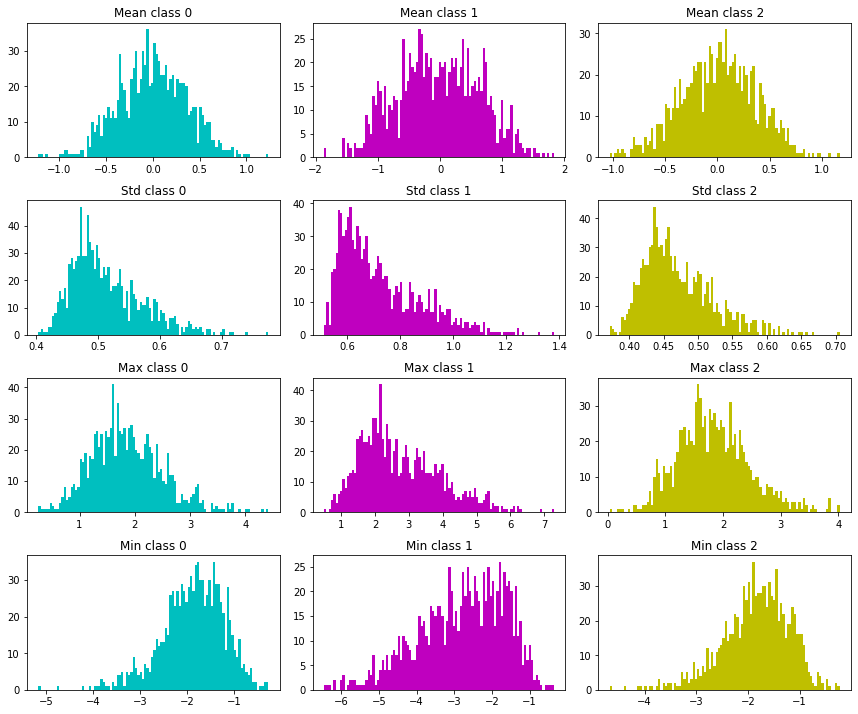

In [54]:
mean0, mean1, mean2 = desc_cls0.loc['mean', :], desc_cls1.loc['mean', :], desc_cls2.loc['mean', :]
std0, std1, std2 = desc_cls0.loc['std', :], desc_cls1.loc['std', :], desc_cls2.loc['std', :]
max0, max1, max2 = desc_cls0.loc['max', :], desc_cls1.loc['max', :], desc_cls2.loc['max', :]
min0, min1, min2 = desc_cls0.loc['min', :], desc_cls1.loc['min', :], desc_cls2.loc['min', :]

fig, axs = plt.subplots(ncols=3, nrows=4)
axs[0][0].hist(mean0, bins=100, color='c')
axs[0][0].set_title('Mean class 0')
axs[0][1].hist(mean1, bins=100, color='m')
axs[0][1].set_title('Mean class 1')
axs[0][2].hist(mean2, bins=100, color='y')
axs[0][2].set_title('Mean class 2')

axs[1][0].hist(std0, bins=100, color='c')
axs[1][0].set_title('Std class 0')
axs[1][1].hist(std1, bins=100, color='m')
axs[1][1].set_title('Std class 1')
axs[1][2].hist(std2, bins=100, color='y')
axs[1][2].set_title('Std class 2')

axs[2][0].hist(max0, bins=100, color='c')
axs[2][0].set_title('Max class 0')
axs[2][1].hist(max1, bins=100, color='m')
axs[2][1].set_title('Max class 1')
axs[2][2].hist(max2, bins=100, color='y')
axs[2][2].set_title('Max class 2')

axs[3][0].hist(min0, bins=100, color='c')
axs[3][0].set_title('Min class 0')
axs[3][1].hist(min1, bins=100, color='m')
axs[3][1].set_title('Min class 1')
axs[3][2].hist(min2, bins=100, color='y')
axs[3][2].set_title('Min class 2')

fig.tight_layout(pad=1.0)

### Clean, split and normalize the data

The raw data has no apperent issues. It looks like we don't have any cleaning to do.

In [ ]:
cleaned_df = raw_df.copy()

Split the dataset into train, validation, and test sets. The validation set is used during the model fitting to evaluate the loss and any metrics, however the model is not fit with this data. The test set is completely unused during the training phase and is only used at the end to evaluate how well the model generalizes to new data. This is especially important with imbalanced datasets where [overfitting](https://developers.google.com/machine-learning/crash-course/generalization/peril-of-overfitting) is a significant concern from the lack of training data.

In [ ]:
all_labels = np.array(cleaned_df.loc[:, 'y'])

# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(cleaned_df, stratify=all_labels, test_size=0.15)
train_labels = np.array(train_df.loc[:, 'y'])
train_df, val_df = train_test_split(train_df, stratify=train_labels, test_size=0.15)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('y'))
val_labels = np.array(val_df.pop('y'))
test_labels = np.array(test_df.pop('y'))

# get features
train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

# form boolean arrays for plotting
cls0_bool = train_labels == 0
cls1_bool = train_labels == 1
cls2_bool = train_labels == 2

# one-hot encode labels for multiclass model
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=3, dtype='int')
val_labels = tf.keras.utils.to_categorical(val_labels, num_classes=3, dtype='int')
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=3, dtype='int')

Normalize the input features using the sklearn StandardScaler.
This will set the mean to 0 and standard deviation to 1.

Note: The `StandardScaler` is only fit using the `train_features` to be sure the model is not peeking at the validation or test sets. 

In [ ]:
#scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

#train_features = np.clip(train_features, -5, 5)
#val_features = np.clip(val_features, -5, 5)
#test_features = np.clip(test_features, -5, 5)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Caution: If you want to deploy a model, it's critical that you preserve the preprocessing calculations. The easiest way to implement them as layers, and attach them to your model before export.


### Look at the data distribution

Next compare the distributions of the classes over a few features. Good questions to ask yourself at this point are:

* Do these distributions make sense? 
    * Yes. You've normalized the input and these are mostly concentrated in the `+/- 2` range.
* Can you see the difference between the distributions?
    * Yes the bigger class contains a much higher rate of extreme values.

In [ ]:
cls0_df = pd.DataFrame(train_features[cls0_bool], columns = train_df.columns)
cls1_df = pd.DataFrame(train_features[cls1_bool], columns = train_df.columns)
cls2_df = pd.DataFrame(train_features[cls2_bool], columns = train_df.columns)

fig, axs = plt.subplots(3)
axs[0].scatter(cls0_df['x11'], cls0_df['x101'])
axs[0].set_title('Class 0')
axs[1].scatter(cls1_df['x11'], cls1_df['x101'])
axs[1].set_title('Class 1')
axs[2].scatter(cls2_df['x11'], cls2_df['x101'])
axs[2].set_title('Class 2')

for ax in axs.flat:
    ax.set(xlabel='x11', ylabel='x101')
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

## Define the model and metrics

Define a function that creates a simple neural network with a densly connected hidden layer, a [dropout](https://developers.google.com/machine-learning/glossary/#dropout_regularization) layer to reduce overfitting, and an output softmax layer ("[This is to ensure the output values are in the range of 0 and 1 and may be used as predicted probabilities.](https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/)")

In [ ]:
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None)
]

def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
          keras.layers.Dense(
              16, activation='relu',
              input_shape=(train_features.shape[-1],)),
          keras.layers.Dropout(0.5),
          keras.layers.Dense(3, activation='softmax')])
    model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=metrics,
        weighted_metrics=['categorical_accuracy'])
    return model

### Understanding useful metrics

Notice that there are a few metrics defined above that can be computed by the model that will be helpful when evaluating the performance.



*   **False** negatives and **false** positives are samples that were **incorrectly** classified
*   **True** negatives and **true** positives are samples that were **correctly** classified
*   **Accuracy** is the percentage of examples correctly classified
>   $\frac{\text{true samples}}{\text{total samples}}$
*   **Precision** is the percentage of **predicted** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false positives}}$
*   **Recall** is the percentage of **actual** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false negatives}}$
*   **AUC** refers to the Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC). This metric is equal to the probability that a classifier will rank a random positive sample higher than a random negative sample.

Note: Accuracy is not a helpful metric for this task. You can 99.8%+ accuracy on this task by predicting False all the time.  

Read more:
*  [True vs. False and Positive vs. Negative](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative)
*  [Accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy)
*   [Precision and Recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)
*   [ROC-AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)

## Baseline model

### Build the model

Now create and train your model using the function that was defined earlier. Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no fraudulent transactions to learn from.


Note: this model will not handle the class imbalance well. You will improve it later in this tutorial.

In [ ]:
EPOCHS = 200
BATCH_SIZE = 256

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
model = make_model()
model.summary()

Test run the model:

In [ ]:
model.predict(train_features[:10])

### Optional: Set the correct initial bias.

### Multiclass classification
These initial guesses are not great. You know the dataset is imbalanced. Set the output layer's bias to reflect that  [See: setting bias for multiclass classification python tensorflow keras](https://stackoverflow.com/questions/60307239/setting-bias-for-multiclass-classification-python-tensorflow-keras).  This can help with initial convergence.

With the frequencies of the three classes as $ f_1 $, $ f_2 $, $ f_3 $ and the biases as $ b_1 $, $ b_2 $, $ b_3 $:
$$ f_1 = e^{b_1} / (e^{b_1} + e^{b_2} + e^{b_3}) $$
$$ f_2 = e^{b_2} / (e^{b_1} + e^{b_2} + e^{b_3}) $$
$$ f_3 = e^{b_3} / (e^{b_1} + e^{b_2} + e^{b_3}) $$

Setting $ (e^b_1 + e^b_2 + e^b_3) $ as $ x $:
$$ e^{b_1} / x = f_1 $$
$$ e^{b_2} / x = f_2 $$
$$ e^{b_3} / x = f_3 $$

In our case:
$$ e^{b_1} / x = 0.125 $$
$$ e^{b_2} / x = 0.75 $$
$$ e^{b_3} / x = 0.125 $$

That means:
$$ e^{b_1} = 0.125 * x $$
$$ e^{b_2} = 0.75 * x $$
$$ e^{b_3} = 0.125 * x $$

Setting $ x = 1 $:
$$ log_e(b_1) = 0.125 $$
$$ log_e(b_2) = 0.75 $$
$$ log_e(b_3) = 0.125 $$

And finally solving for $b$ to get our initial biases:
$$ b_1 = log_e(0.125) \approx -2.08 $$
$$ b_2 = log_e(0.75) \approx -0.29 $$
$$ b_3 = log_e(0.125) \approx -2.08 $$

In [ ]:
initial_bias0 = -2.08
initial_bias1 = -0.29
initial_bias2 = -2.08
initial_bias = np.array([initial_bias0, initial_bias1, initial_bias2])
initial_bias

In [ ]:
model = make_model(output_bias = initial_bias)
model.predict(train_features[:10])

### Checkpoint the initial weights

To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training.

In [ ]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

### Confirm that the bias fix helps

Before moving on, confirm quick that the careful bias initialization actually helped.

Train the model for 20 epochs, with and without this careful initialization, and compare the losses: 

In [ ]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0, 0.0, 0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [ ]:
model = make_model(output_bias = initial_bias)
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [ ]:
def plot_loss(history, label, n):
    # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'],
                   color=colors[n], label='Train '+label)
    plt.semilogy(history.epoch,  history.history['val_loss'],
                color=colors[n], label='Val '+label,
                linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

In [ ]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

The above figure makes it clear: In terms of validation loss, on this problem, this careful initialization gives a clear advantage. 

### Train the model

In [ ]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels),
    verbose=0)

### Check training history
In this section, you will produce plots of your model's accuracy and loss on the training and validation set. These are useful to check for overfitting, which you can learn more about in this [tutorial](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

Additionally, you can produce these plots for any of the metrics you created above. False negatives are included as an example.

In [ ]:
def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])
        plt.legend()


In [ ]:
plot_metrics(baseline_history)

Note: That the validation curve generally performs better than the training curve. This is mainly caused by the fact that the dropout layer is not active when evaluating the model.

### Evaluate metrics

You can use a [confusion matrix](https://developers.google.com/machine-learning/glossary/#confusion_matrix) to summarize the actual vs. predicted labels where the X axis is the predicted label and the Y axis is the actual label.

In [ ]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [ ]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels.argmax(axis=1), predictions.argmax(axis=1))
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    print('')
    print('Class 0:')
    print('True predictions = ', cm[0][0])
    print('False positives = ', cm[1][0] + cm[2][0])
    print('False negatives = ', cm[0][1] + cm[0][2])
    print('')
    print('Class 1:')
    print('True predictions = ', cm[1][1])
    print('False positives = ', cm[0][1] + cm[2][1])
    print('False negatives = ', cm[1][0] + cm[1][2])
    print('')
    print('Class 2:')
    print('True predictions = ', cm[2][2])
    print('False positives = ', cm[0][2] + cm[1][2])
    print('False negatives = ', cm[2][0] + cm[2][1])

    print(np.sum(cm[1]))

Evaluate your model on the test dataset and display the results for the metrics you created above.

In [ ]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)

plot_cm(test_labels, test_predictions_baseline)

### Calculate BMAC

In [ ]:
prediction = np.argmax(test_predictions_baseline, -1)
unhotted_test_labs = np.argmax(test_labels, -1)
BMAC = balanced_accuracy_score(unhotted_test_labs, prediction)
print('BMAC: %.3f' % BMAC)

If the model had predicted everything perfectly, this would be a [diagonal matrix](https://en.wikipedia.org/wiki/Diagonal_matrix) where values off the main diagonal, indicating incorrect predictions, would be zero. In this case the matrix shows that you have relatively few false positives. However, you would likely want to have even fewer false negatives despite the cost of increasing the number of false positives. This trade off may be preferable..

## Class weights

### Calculate class weights

Passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [ ]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / cls0)*(total)/3.0 
weight_for_1 = (1 / cls1)*(total)/3.0
weight_for_2 = (1 / cls2)*(total)/3.0

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))

### Train a model with class weights

Now try re-training and evaluating the model with class weights to see how that affects the predictions.

Note: Using `class_weights` changes the range of the loss. This may affect the stability of the training depending on the optimizer. Optimizers whose step size is dependent on the magnitude of the gradient, like `optimizers.SGD`, may fail. The optimizer used here, `optimizers.Adam`, is unaffected by the scaling change. Also note that because of the weighting, the total losses are not comparable between the two models.

In [ ]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)
weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels),
    verbose=0,
    # The class weights go here
    class_weight=class_weight) 

### Check training history

In [ ]:
plot_metrics(weighted_history)

### Evaluate metrics

In [ ]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

In [ ]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

### Calculate BMAC

In [ ]:
prediction = np.argmax(test_predictions_weighted, -1)
unhotted_test_labs = np.argmax(test_labels, -1)
BMAC = balanced_accuracy_score(unhotted_test_labs, prediction)
print('BMAC: %.3f' % BMAC)

Here you can see that with class weights the accuracy and precision are lower because there are more false positives, but conversely the recall and AUC are higher because the model also found more true positives. Despite having lower accuracy, this model has higher recall (and identifies more fraudulent transactions). Of course, there is a cost to both types of error (you wouldn't want to bug users by flagging too many legitimate transactions as fraudulent, either). Carefully consider the trade-offs between these different types of errors for your application.

## Oversampling

### Oversample the minority class

A related approach would be to resample the dataset by oversampling the minority classes.

In [ ]:
cls0_features = train_features[cls0_bool]
cls1_features = train_features[cls1_bool]
cls2_features = train_features[cls2_bool]

cls0_labels = train_labels[cls0_bool]
cls1_labels = train_labels[cls1_bool]
cls2_labels = train_labels[cls2_bool]

#### Using `tf.data`

If you're using `tf.data` the easiest way to produce balanced examples is to start with creating three separate datasets for the three classes and then merge them. See [the tf.data guide](../../guide/data.ipynb) for more examples.

In [ ]:
BUFFER_SIZE = 10000

def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((features, labels)) #.cache()
    ds = ds.shuffle(BUFFER_SIZE).repeat()
    return ds

cls0_ds = make_ds(cls0_features, cls0_labels)
cls1_ds = make_ds(cls1_features, cls1_labels)
cls2_ds = make_ds(cls2_features, cls2_labels)

Each dataset provides `(feature, label)` pairs:

In [ ]:
for features, label in cls1_ds.take(1):
    print("Features:\n", features.numpy()[0:25])
    print()
    print("Label: ", label.numpy())

Merge the three together using `experimental.sample_from_datasets`:

In [ ]:
resampled_ds = tf.data.experimental.sample_from_datasets([cls0_ds, cls1_ds, cls2_ds], weights=[0.3, 0.3, 0.3])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [ ]:
for features, label in resampled_ds.take(1):
    print(label.numpy()[1:10])
    print(len(label.numpy()))

To use this dataset, you'll need the number of steps per epoch.

The definition of "epoch" in this case is less clear. Say it's the number of batches required to see each negative example once:

In [ ]:
resampled_steps_per_epoch = np.ceil(3.0*cls1/BATCH_SIZE)
resampled_steps_per_epoch

### Train on the oversampled data

Now try training the model with the resampled data set instead of using class weights to see how these methods compare.

Note: Because the data was balanced by replicating the two minority classes, the total dataset size is larger, and each epoch runs for more training steps. 

In [ ]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0, 0, 0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks = [early_stopping],
    validation_data=val_ds,
    verbose=0)

If the training process were considering the whole dataset on each gradient update, this oversampling would be basically identical to the class weighting.

But when training the model batch-wise, as you did here, the oversampled data provides a smoother gradient signal: Instead of each positive example being shown in one batch with a large weight, they're shown in many different batches each time with a small weight. 

This smoother gradient signal makes it easier to train the model.

### Check training history

Note that the distributions of metrics will be different here, because the training data has a totally different distribution from the validation and test data. 

In [ ]:
plot_metrics(resampled_history)

### Re-train


Because training is easier on the balanced data, the above training procedure may overfit quickly. 

So break up the epochs to give the `callbacks.EarlyStopping` finer control over when to stop training.

In [ ]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0, 0, 0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch = 20,
    epochs=10*EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_ds),
    verbose=0)

### Re-check training history

In [ ]:
plot_metrics(resampled_history)

### Evaluate metrics

In [ ]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

In [ ]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

### Calculate BMAC

In [ ]:
prediction = np.argmax(test_predictions_resampled, -1)
unhotted_test_labs = np.argmax(test_labels, -1)
BMAC = balanced_accuracy_score(unhotted_test_labs, prediction)
print('BMAC: %.3f' % BMAC)